# Semantic Segmentation Models
Click to open in: [[GitHub](https://github.com/TissueImageAnalytics/tiatoolbox/tree/master/examples/06-semantic-segmentation.ipynb)][[Colab](https://colab.research.google.com/github/TissueImageAnalytics/tiatoolbox/blob/master/examples/06-semantic-segmentation.ipynb)][[Kaggle](https://kaggle.com/kernels/welcome?src=https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/examples/06-semantic-segmentation.ipynb)]


_In order to run this notebook on a Kaggle platform, 1) click the Kaggle URL 2) click on Settings on the right of the Kaggle screen, 3) log in to your Kaggle account, 4) tick "Internet" checkbox under Settings, to enable necessary downloads._

_If you are using google Colab, for faster responses you should enable the use of GPU for this session through (menu) Runtime ⟶ Change runtime type ⟶ Set "Hardware Accelator" to "GPU"._

## About this notebook
This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory or Kaggle. To connect with Colab or Kaggle, click on one of the URLs above. Check that "colab" or "kaggle", as appropriate, appears in the address bar. You can right click on "Open in Colab" and select "Open in new tab" if left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on GitHub, Colab or Kaggle, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab or Kaggle, set up your Python environment, as explained in the
[README](https://tia-toolbox.readthedocs.io/en/develop/installation.html) file.

## About this demo
Semantic segmentation in image processing means partitioning the image into its constructing segments so that each segment corresponds to a specific category of an object present in the image. In other words, semantic segmentation can be considered as classifying each pixel in the image into a pre-defined category. Note that semantic segmentation does not differentiate instances of the same object, like the figure below which shows three examples of road images with their semantic segmentation. You can see how all objects of the same class have the same colour (please refer to [here](https://www.cs.toronto.edu/~tingwuwang/semantic_segmentation.pdf) and [here](https://nanonets.com/blog/semantic-image-segmentation-2020/) to find more information on the semantic segmentation task).
>![image](https://tiatoolbox.dcs.warwick.ac.uk/notebook/semantic_road.PNG)
> Image courtesy of: Chen, Liang-Chieh, et al. "Deeplab: Semantic image segmentation with deep convolutional nets, atrous convolution, and fully connected crfs." IEEE transactions on pattern analysis and machine intelligence 40.4 (2017): 834-848.

Similar to natural images, semantic segmentation of histology images is the task of identifying the class of each pixel in the image based on the object or tissue type of the region encompassing that pixel.
Semantic segmentation of tissue regions in histology images plays an important role in developing algorithms for cancer diagnosis and prognosis as it can help measure tissue attributes in an objective and reproducible fashion.
>![image](https://tiatoolbox.dcs.warwick.ac.uk/notebook/semantic_histology.png)
>Example of semantic segmentation in histology images where pixels are classified based on different region types including tumour, fat, inflammatory, necrosis etc.

In this example notebook, we are showing how you can use pretrained models to do automatically segment different tissue region types in a set of input images or WSIs. We first focus on a pretrained model incorporated in the TIAToolbox to achieve semantic annotation of tissue region in histology images of breast cancer. After that, we will explain how you can use your pretrained model in the TIAToolbox model inference pipeline to do prediction on a set WSIs.

### Setting up the environment
The cell below removes some redundant directories of they exist—a previous run may have created them. This cell can be skipped if you are running this notebook for the first time.

In [10]:
![ -d tmp ] && ( echo "deleting tmp directory"; rm -rf tmp )
![ -d sample_tile_results ] && !( echo "deleting 'sample_tile_results' directory"; rm -r sample_tile_results)
![ -d sample_wsi_results ] && ( echo "deleting 'sample_wsi_results' directory"; rm -r sample_wsi_results)
![ -d tissue_mask_results ] && ( echo "deleting 'tissue_mask_results' directory"; rm -r tissue_mask_results)
import warnings
warnings.filterwarnings('ignore')

You can skip the following cell if 1) you are not using the Colab or Kaggle platforms or 2) you are using Colab or Kaggle and this is not your first run of the notebook in the current session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab or Kaggle the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab or Kaggle, the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://tia-toolbox.readthedocs.io/en/develop/installation.html).)

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install tiatoolbox | tail --line 1
ON_GPU = False
print('Installation is done.')

**[optional]**: if you are running this example notebook on your system, and it is equipped with a Cuda enabled GPU, you can run the following cell to install Cuda enabled version of the torch package to utilize GPU computation and speed up the TIAToolbox models.

In [1]:
#!pip install torch==1.9.1+cu102 torchvision==0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html --user
ON_GPU = False

### Importing related libraries

We import some standard Python modules, and also the Python module `wsireader` (see [details](https://github.com/TIA-Lab/tiatoolbox/blob/master/tiatoolbox/wsicore/wsireader.py)) written by the TIA Centre team.

In [2]:
from tiatoolbox.models.engine.semantic_segmentor import IOSegmentorConfig, SemanticSegmentor
from tiatoolbox.utils.misc import imread
from tiatoolbox.wsicore.wsireader import WSIReader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob

mpl.rcParams['figure.dpi'] = 300 # for high resolution figure in notebook

### Downloading the required files
We download, over the internet, image files used for the purpose of this notebook. In particular, we download a histology tile and a whole slide image of cancerous breast tissue samples to show how semantic segmentation models work. Also, pretrained weights of a Pytorch model and a small WSI are downloaded to illustrate how you can incorporate your own models in the existing TIAToolbox segmentation tool.
> In Colab, if you click the files icon (see below) in the vertical toolbar on the left hand side then you can see all the files which the code in this notebook can access. The data will appear here when it is downloaded.
>
> 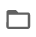

In [14]:
from tiatoolbox.utils.misc import download_data

# These file name are used for
img_file_name = "sample_tile.jpg"
wsi_file_name = r"C:\\Analysis_Studies\\22-108 LifeNet\\Images\\22-108 HE 2122623.mrxs"
mini_wsi_file_name = r"C:\\Analysis_Studies\\22-108 LifeNet\\Images\\22-108 HE 2122623.mrxs"
model_file_name = "tissue_mask_model.pth"

print('Download has started. Please wait...')

# Downloading sample image tile
download_data("https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/breast_tissue.jpg", img_file_name)

# Downloading sample whole-slide image
download_data("https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/wsi4_12k_12k.svs", wsi_file_name)

# Downloading mini whole-slide image
download_data("https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/CMU-1.ndpi", mini_wsi_file_name)

# Download external model
download_data("https://tiatoolbox.dcs.warwick.ac.uk//models/seg/fcn-tissue_mask.pth", model_file_name)

print('Download is complete.')

Download has started. Please wait...
Download from https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/breast_tissue.jpg
Save to sample_tile.jpg
Download from https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/wsi4_12k_12k.svs
Save to C:\\Analysis_Studies\\22-108 LifeNet\\Images\\22-108 HE 2122623.mrxs
Download from https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/CMU-1.ndpi
Save to C:\\Analysis_Studies\\22-108 LifeNet\\Images\\22-108 HE 2122623.mrxs
Download from https://tiatoolbox.dcs.warwick.ac.uk//models/seg/fcn-tissue_mask.pth
Save to tissue_mask_model.pth
Download is complete.


## Semantic segmentation using TIAToolbox pretrained models
In this section, we will investigate the use of semantic segmentation models that have been already trained on a specific task and incorporated in the TIAToolbox.
Particularly, the model we demonstrate can estimate the probability of each pixel in an image (tile or whole slide images) of breast cancer sample belonging to one of the following classes:
- Tumour
- Stroma
- Inflammatory
- Necrosis
- Others (nerves, vessels, blood cells, adipose, etc.)

> More information on the model and the dataset used for training can be found [here](https://academic.oup.com/bioinformatics/article/35/18/3461/5307750) (_Amgad et al., "Structured crowdsourcing enables convolutional segmentation of histology image"_) and the data is available for download using this [link](https://github.com/PathologyDataScience/BCSS).

### Inference on tiles
Much similar to the patch classifier functionality of the tiatoolbox, the semantic segmentation module works both on image tiles and structured WSIs. First, we need to create an instance of the  `SemanticSegmentor` class which controls the  whole process of semantic segmentation task and then use it to do prediction on the input image(s):

In [6]:
# Tile prediction
bcc_segmentor = SemanticSegmentor(
    pretrained_model="fcn_resnet50_unet-bcss",
    num_loader_workers=4, batch_size=4,
)

output = bcc_segmentor.predict(
        [img_file_name],
        save_dir="sample_tile_results/",
        mode="tile",
        resolution=1.0,
        units="baseline",
        patch_input_shape=[1024, 1024],
        patch_output_shape=[512, 512],
        stride_shape=[512, 512],
        on_gpu=ON_GPU,
        crash_on_exception=True,
    )

|2022-02-19|20:48:13.082| [WARNING] c:\dev\tiatoolbox\tiatoolbox\models\engine\semantic_segmentor.py:1026: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
  warnings.warn(



Download from https://tiatoolbox.dcs.warwick.ac.uk/models/seg/fcn_resnet50_unet-bcss.pth
Save to C:\Users\analysis_bluedot\.tiatoolbox\models/fcn_resnet50_unet-bcss.pth


|2022-02-19|20:48:13.207| [WARNING] c:\dev\tiatoolbox\tiatoolbox\models\engine\semantic_segmentor.py:274: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
  warnings.warn(

|2022-02-19|20:48:13.507| [WARNING] c:\dev\tiatoolbox\tiatoolbox\wsicore\wsimeta.py:174: UserWarning: Raw data is None
  warnings.warn("Raw data is None")

|2022-02-19|20:48:13.507| [WARNING] c:\dev\tiatoolbox\tiatoolbox\wsicore\wsimeta.py:177: UserWarning: Unknown scale (no objective_power or mpp)
  warnings.warn("Unknown scale (no objective_power or mpp)")

Process Batch: 100%|############################| 16/16 [03:05<00:00, 11.58s/it]
|2022-02-19|20:51:20.210| [INFO] Finish: 0/1
|2022-02-19|20:51:20.210| [INFO] --Input: sample_tile.jpg
|2022-02-19|20:51:20.211| [INFO] --Ouput: c:\dev\tiatoolbox\sample_tile_results\0


There we go! With only two lines of code, thousands of images can be processed automatically.
There are many parameters associated with `SemanticSegmentor`. We explain these as we meet them, while proceeding through the notebook. Here we explain only the ones mentioned above:

- `pretrain_model`: specifies the name of the pretrained model included in the TIAToolbox (case-sensitive). We are expanding our library of models pretrained on various segmentation tasks. You can find a complete list of available pretrained models [here](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=architecture#module-tiatoolbox.models.architecture). In this example, we use the `"fcn_resnet50_unet-bcss"` pretrained model, which is a fully convolutional network that follows [UNet](https://arxiv.org/abs/1505.04597) network architecture and benefits from a [ResNet50](https://arxiv.org/abs/1512.03385) model as its encoder part.

- `num_loader_workers`: as the name suggests, this parameter controls the number of CPU cores (workers) that are responsible for the "loading of network input" process, which consists of patch extraction, preprocessing, etc.

- `batch_size`: controls the batch size, or the number of input instances to the network in each iteration. If you use a GPU, be careful not to set the `batch_size` larger than the GPU memory limit would allow.

After the `bcc_segmentor` has been instantiated as a semantic segmentation engine with our desired pretrained model, one can call the `predict` method to do inference on a list of input images (or WSIs). The `predict` function automatically processes all the images on the input list and saves the results on the disk. The process usually comprises patch extraction (because the whole tile or WSI won't fit into limited GPU memory), preprocessing, model inference, post-processing and prediction assembly. There some important parameters that should be set to use the `predict` method properly:

- `imgs`: List of inputs to be processed. Note that items in the list should be paths to the inputs stored on the disk.

- `save_dir`: Path to the main folder in which prediction results for each input will be stored separately.

- `mode`: the mode of inference which can be set to either `'tile'` or `'wsi'` for plain histology images or structured whole slides images, respectively.

- `resolution` and `unit`: specify the resolution on which we want to process the input. Because plain images only have a baseline layer, the options in this case should always be the defaults `units="baseline"` and `resolution=1.0` and, as defaults, can be omitted.

- `patch_input_shape`: the shape of the patches extracted from the input image (WSI) to be fed into the model. The bigger the patch size the more GPU memory is needed.

- `patch_output_shape`: The expected shape of output prediction maps for patches. This should be set based on the knowledge we have from the model design. For example, we know that the shape of output maps from `"fcn_resnet50_unet-bcss"` model is half of the input shape in each dimension. Therefore, as we set the `patch_input_shape=[1024, 1024]`), we need to set the `patch_output_shape=[512, 512]`.

- `stride_shape`: Stride of output patches during tile and WSI processing. This parameter is used to set the amount of overlap between neighbouring prediction patches. Based on this parameter, the toolbox automatically calculates the patch extraction stride.

- `on_gpu`: can be either `True` or `False` to dictate running the computations on GPU or CPU.

- `crash_on_exception`: If set to `True`, the running loop will crash if there is an error during processing a WSI. Otherwise, the loop will move on to the next image (wsi) for processing. We suggest that you first make sure that prediction is working as expected by testing it on a couple of inputs and then set this flag to `False` to process large cohorts of inputs.

We should mention that when you are using TIAToolbox pretrained models, you don't need to worry about setting the input/output shape parameters as their optimal values will be loaded by default.

In the `output`, the `prediction` method returns a list of the paths to its inputs and to the processed outputs saved on the disk. This can be used for loading the results for processing and visualisation.

prediction method output is: [['sample_tile.jpg', 'c:\\dev\\tiatoolbox\\sample_tile_results\\0']]
Raw prediction dimensions: (4000, 4000, 5)
Processed prediction dimensions: (4000, 4000)
Input image dimensions: (4000, 4000, 3)


Text(0.5, 0.82, 'Processed prediction map')

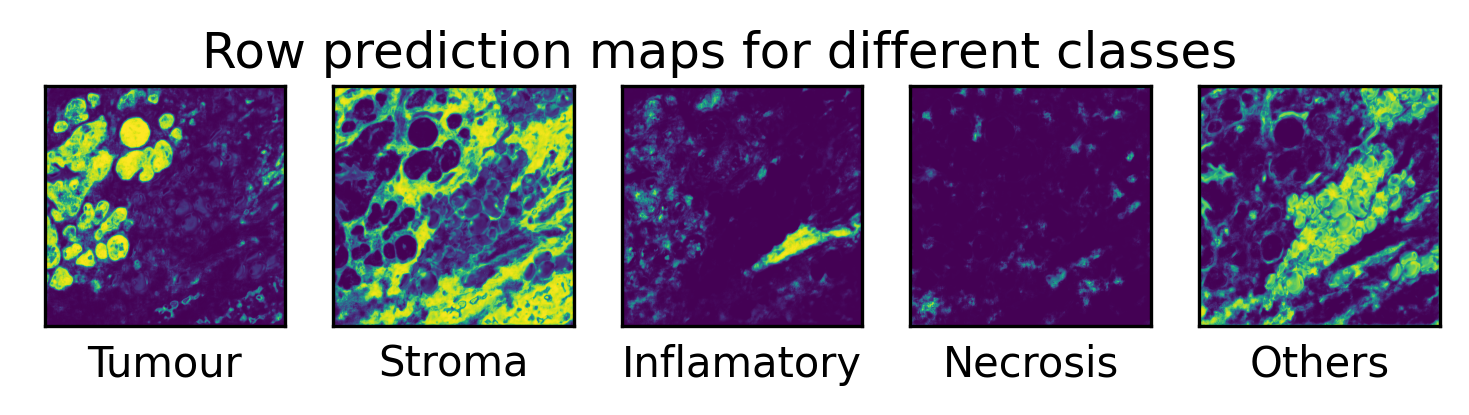

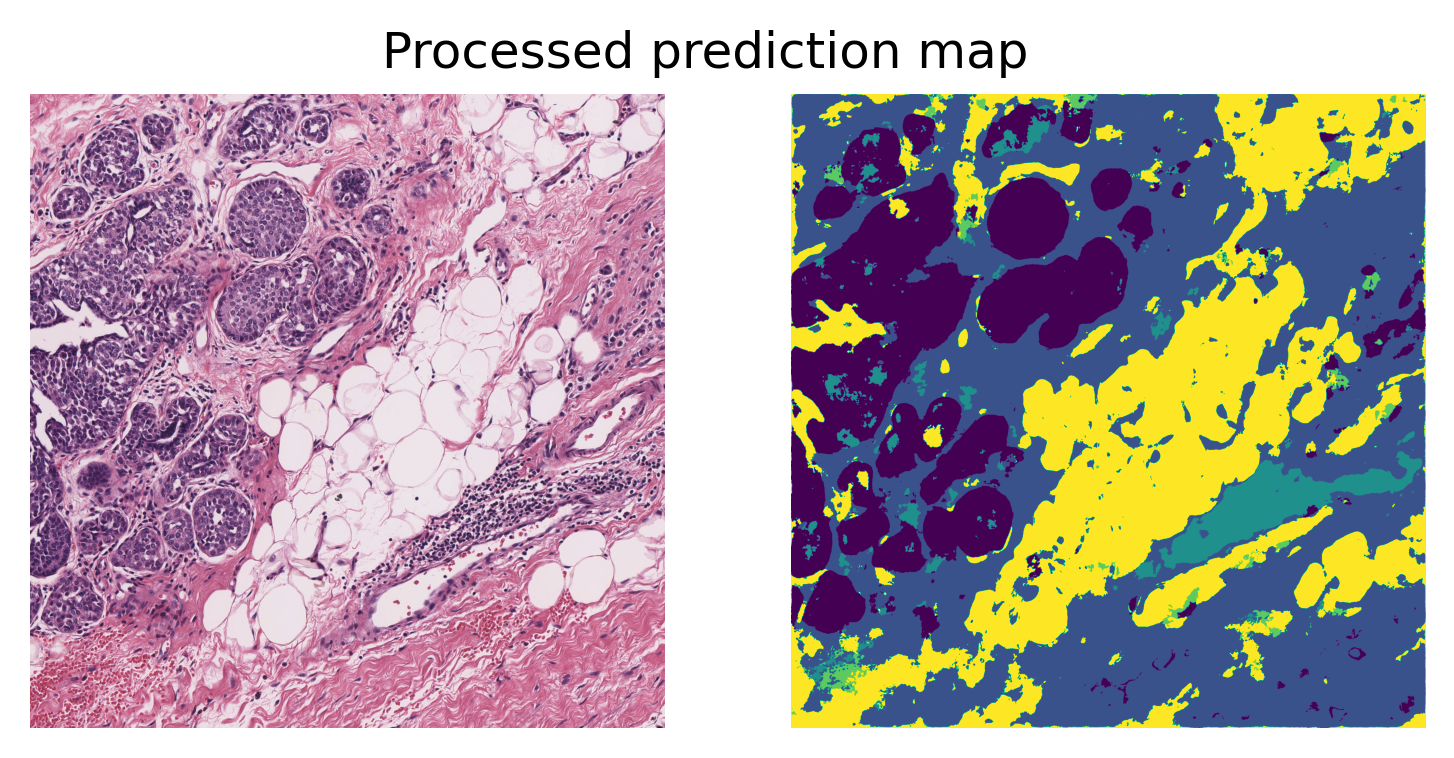

In [7]:
print('prediction method output is: {}'.format(output))
tile_prediction_raw = np.load(output[0][1]+'.raw.0.npy') # Loading the first prediction [0] based on the output address [1]
print('Raw prediction dimensions: {}'.format(tile_prediction_raw.shape))

# Simple processing of the raw prediction to generate semantic segmentation task
tile_prediction = np.argmax(tile_prediction_raw, axis=-1) # select the class with highest probability
print('Processed prediction dimensions: {}'.format(tile_prediction.shape))

# showing the predicted semantic segmentation
tile = imread(img_file_name)
print('Input image dimensions: {}'.format(tile.shape))

fig = plt.figure()
label_names_dict = {0: 'Tumour', 1: 'Stroma', 2: 'Inflamatory', 3: 'Necrosis', 4: 'Others'}
for i in range(5):
  ax = plt.subplot(1,5,i+1)
  plt.imshow(tile_prediction_raw[:, :, i]), plt.xlabel(label_names_dict[i]), ax.axes.xaxis.set_ticks([]), ax.axes.yaxis.set_ticks([])
fig.suptitle('Row prediction maps for different classes', y=0.65)

# showing processed results
fig2 = plt.figure()
ax1 = plt.subplot(1,2,1), plt.imshow(tile), plt.axis('off')
ax2 = plt.subplot(1,2,2), plt.imshow(tile_prediction), plt.axis('off')
fig2.suptitle('Processed prediction map', y=0.82)


As printed above, the raw prediction array has 5 channels (size 4000x4000x**5**) which indicate the 5 categories that our segmentation model can distinguish. These prediction channels are illustrated in the first row, one-by-one, where each prediction map stands for a specific tissue region class. However, the idea is to have a single prediction map that contains specific values for each class. Therefore, we use a very simple post-processing technique to acquire the semantic segmentation map:
> `tile_prediction = np.argmax(tile_prediction_raw, axis=-1)`

that finds, for each pixel, the class index that has the highest estimated probability. In the processed prediction map dark blue, light blue, dark green, light green, and yellow colours stand for tumour, stroma, inflamatory, necrosis, and other region types, respectively.

### Inference on WSIs
The next step is to use the TIAToolbox's embedded model for region segmentation in a whole slide image. The process is quite similar to what we have done for tiles. Here we just introduce a some important parameters that should be considered when configuring the segmentor for WSI inference.

In [17]:
bcc_segmentor = SemanticSegmentor(
    pretrained_model="fcn_resnet50_unet-bcss",
    num_loader_workers=4, batch_size=4,
    auto_generate_mask=False
)

bcc_wsi_ioconfig = IOSegmentorConfig(
    input_resolutions=[
            {'units': 'mpp', 'resolution': 8}
        ],
        output_resolutions=[
            {'units': 'mpp', 'resolution': 8}
        ],
        patch_input_shape=[1024, 1024],
        patch_output_shape=[512, 512],
        stride_shape=[512, 512],
        save_resolution={'units': 'mpp', 'resolution': 2}
)

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/seg/fcn_resnet50_unet-bcss.pth
Save to C:\Users\analysis_bluedot\.tiatoolbox\models/fcn_resnet50_unet-bcss.pth


Here we re-defined the `bcc_segmentor` just to show the use of `auto_generate_mask` parameter. By setting this parameter to `True`, we are telling the TIAToolbox to automatically extract the tissue masks of the input WSIs if they are not provided in the `predict` function parameters.
In this example, we leave `auto_generate_mask=False` because we are using a WSI that only contains tissue region (there is no background region) and therefore there is no need for tissue mask extraction.

When doing inference on WSIs, it is important to set the data stream configurations (such as input resolution, output resolution, size of merged predictions, etc.) appropriately for each model and application. In TIAToolbox, `IOSegmentorConfig` class is used to set these configurations as we have done in the above cell.
Parameters of `IOSegmentorConfig` have self-explanatory names, but let's have look at their definition:
- `input_resolutions`: a list specifying the resolution of each input head of model in the form of a dictionary. List elements must be in the same order as target `model.forward()`. Of course, if your model accepts only one input, you just need to put one dictionary specifying `'units'` and `'resolution'`. But it's good to know that TIAToolbox supports a model with more than one input!
- `output_resolutions`: a list specifying the resolution of each output head from model in the form of a dictionary. List elements must be in the same order as target `model.infer_batch()`.
- `patch_input_shape`: Shape of the largest input in (height, width) format.
- `patch_output_shape`: Shape of the largest output in (height, width) format.
- `save_resolution`: specifies the resolution in which processed (merged) output will be saved. Commonly, we desire the resolution (size) of the output segmentation map to be smaller than the input map. For example, we don't need the tissue segmentation results to be as high-resolution as input WSI. Therefore, this parameter can be set based on the model, task, and desired output size.




In [19]:
# WSI prediction
wsi_output = bcc_segmentor.predict(
        imgs=[wsi_file_name],
        masks=None,
        save_dir="sample_wsi_results/",
        mode="wsi",
        ioconfig=bcc_wsi_ioconfig,
        on_gpu=ON_GPU,
        crash_on_exception=True,
    )

Process Batch: 100%|############################| 18/18 [09:02<00:00, 30.16s/it]
|2022-02-19|21:32:04.198| [INFO] Finish: 0/1
|2022-02-19|21:32:04.199| [INFO] --Input: C:\\Analysis_Studies\\22-108 LifeNet\\Images\\22-108 HE 2122623.mrxs
|2022-02-19|21:32:04.199| [INFO] --Ouput: c:\dev\tiatoolbox\sample_wsi_results\0


Note the only differences made here are:
1. Adding `auto_generate_mask=False` to the `SemanticSegmentor`. If `True`, the toolbox automatically extracts tissue masks from WSIs if there is no `masks` input is provided to the `predict` function.
2. Setting `mode='wsi'` in the `predict` function indicates that we are predicting region segmentations for inputs in the form of WSIs.
3. `masks=None` in the `predict` function: `masks` argument similar to the `imgs` should be a list of paths to the desired image masks. Patches from `imgs` are only processed if they are within a masked area of their corresponding `masks`. If not provided (`masks=None`), then a tissue mask will be automatically generated for whole-slide images or the entire image is processed for image tiles.

The above cell might take a while to process, especially if you have set `ON_GPU=False`. The processing time depends on the size of the input WSI and the selected resolution. Here, we have not specified any values, which means that the `baseline` resolution of the WSI, which is 40x in this example, will be used.

prediction method output is: [['C:\\\\Analysis_Studies\\\\22-108 LifeNet\\\\Images\\\\22-108 HE 2122623.mrxs', 'c:\\dev\\tiatoolbox\\sample_wsi_results\\0']]
Raw prediction dimensions: (24317, 10670, 5)
Processed prediction dimensions: (24317, 10670)
WSI original dimensions: (88064, 200704)
WSI overview dimensions: (24317, 10670, 3)


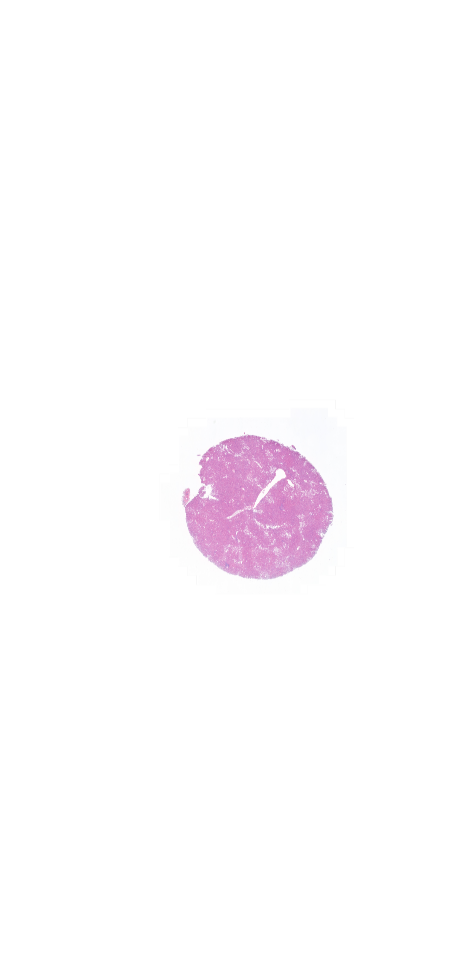

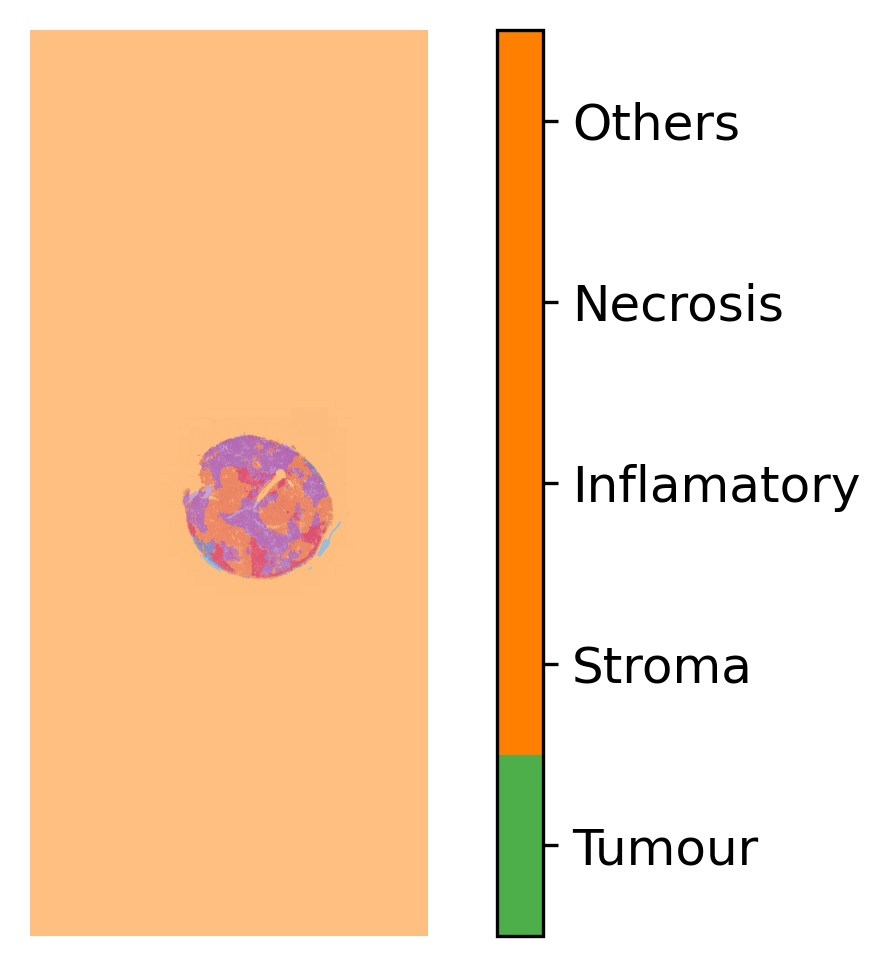

In [20]:
from matplotlib import cm
from tiatoolbox.utils.visualization import overlay_prediction_mask

print('prediction method output is: {}'.format(wsi_output))
wsi_prediction_raw = np.load(wsi_output[0][1]+'.raw.0.npy') # Loading the first prediction [0] based on the output address [1]
print('Raw prediction dimensions: {}'.format(wsi_prediction_raw.shape))

# [Post-processing]
# Simple processing of the raw prediction to generate semantic segmentation task
wsi_prediction = np.argmax(wsi_prediction_raw, axis=-1) # select the class with highest probability
print('Processed prediction dimensions: {}'.format(wsi_prediction.shape))

# [WSI overview extraction]
# Now reading the WSI to extract it's overview
wsi = WSIReader.open(wsi_file_name)
print('WSI original dimensions: {}'.format(wsi.info.slide_dimensions))

# using the prediction save_resolution to create the wsi overview at the same resolution
overview_info = bcc_wsi_ioconfig.save_resolution

# extracting slide overview using `slide_thumbnail` method
wsi_overview = wsi.slide_thumbnail(resolution=overview_info['resolution'], units=overview_info['units'])
print('WSI overview dimensions: {}'.format(wsi_overview.shape))
plt.figure(), plt.imshow(wsi_overview); plt.axis('off')

# [Overlay map creation]
# creating label-color dictionary to be fed into `overlay_prediction_mask` function to help generating color legend
label_dict = {'Tumour': 0, 'Stroma': 1, 'Inflamatory': 2, 'Necrosis':3, 'Others':4}
label_color_dict = {}
colors = cm.get_cmap('Set1').colors
for class_name, label in label_dict.items():
    label_color_dict[label] = (class_name, 255*np.array(colors[label]))
# Creat overlay map using the `overlay_prediction_mask` helper function
overlay = overlay_prediction_mask(wsi_overview, wsi_prediction, alpha=0.5, label_info=label_color_dict)

As you can see above, we first post-process the prediction map, the same way as we did for tiles (taking `argmax` of the model output), to create the semantic segmentation map. Then, in order to visualise the segmentation prediction on the tissue image, we read the processed WSI and extract its overview. Please note that the overview is extracted at the same resolution as the saved prediction output (accessed through `bcc_wsi_ioconfig.save_resolution`). Finally, we used the `overlay_prediction_mask` helper function of the TIAToolbox to overlay the prediction map on the overview image and depict it with a colour legend.

In summary, it is very easy to use pretrained models in the TIAToolbox to do predefined tasks. In fact, you don't even need to set any parameters related to a model’s input/output when you decide to work with one of TIAToolbox’s pretrained models (they will be set automatically, based on their optimal values). Here we explain how the parameters work, so we need to show them explicitly. In other words, region segmentation in images can be done as easily as:
```
segmentor = SemanticSegmentor(pretrained_model="fcn_resnet50_unet-bcss" num_loader_workers=4, batch_size=4)
output = segmentor.predict([img_file_name], save_dir="sample_tile_results/", mode="tile")
```

Having said that, you may need to take care of a couple of other things if you want to use the same model with new weights, or even use a whole new model in the TIAToolbox inference pipeline. But don't worry, these will be covered in the next section of this notebook.

## Semantic segmentation using user-trained (external) models
At the TIACentre we are extending the number of pretrained models in the toolbox as fast as we can, to cover more tasks and tissue types. Nevertheless, users may need to use their own models in the TIAToolbox inference pipeline. In this case, TIAToolbox removes the burden of programing WSI processing, patch extraction, prediction aggregation, and multi-processing handling. Projects at scale provide further complications. But TIAToolbox comes to the rescue!
TIAToolbox supports **Pytorch** models. It's very easy to fit torch models in theTIAToolbox inference pipeline. We show you how.

### Tissue segmentation model as an external model
We have a model that has been trained for tissue mask segmentation i.e., a PyTorch model that has been trained to distinguish between tissue and background, and we want to use it for tissue mask generation (instead of using a simple thresholding technique like Otsu's method).

The first thing to do is to prepare our model. As an illustration of the technique, we use a generic UNet architecture that already been implemented in the TIAToolbox. The section "Downloading the required files" above describes downloading the weights pretrained for segmentation, and these are loaded into the model.

In [21]:
from tiatoolbox.models.architecture.unet import UNetModel
import torch

# define model architecture
external_model = UNetModel(
    num_input_channels = 3, # number of input image channels (3 for RGB)
    num_output_channels = 2, # number of model's output channels. 2 for two classes foreground and background.
    encoder = "resnet50", # model used in the encoder part of the model to extract features
    decoder_block = [3] #  A list of convolution layers (each item specifies the kernel size)
)

# Loading pretrained weights into the model
map_location = torch.device('cuda') if ON_GPU else torch.device('cpu')
pretrained_weights = torch.load(model_file_name, map_location=torch.device('cpu'))
external_model.load_state_dict(pretrained_weights)

<All keys matched successfully>

This is just an example, and you can use any CNN model of your choice. Remember that, in order to use `SemanticSegmentor`, `model` weights should already be loaded: when you pass a `model` argument to `SemanticSegmentor`, the latter ignores the `pretrained_model` and `pretrained_weights` arguments. In other words, the argument `pretrained_weights` is associated with the argument `pretrained_model` and not with the argument `model`.

Now that we have our model in place, let's create our `SemanticSegmentor`. Also, we need to configure the Input/Output stream of data for our model using `IOSegmentorConfig`.

In [22]:
tissue_segmentor = SemanticSegmentor(model=external_model, num_loader_workers=4, batch_size=4)

# define the I/O configurations for tissue segmentation model
tissue_segmentor_ioconfig = IOSegmentorConfig(
    input_resolutions=[
            {'units': 'mpp', 'resolution': 2.0}
        ],
        output_resolutions=[
            {'units': 'mpp', 'resolution': 2.0}
        ],
        patch_input_shape=[1024, 1024],
        patch_output_shape=[512, 512],
        stride_shape=[512, 512],
        save_resolution={'units': 'mpp', 'resolution': 8.0}
)

Now, everything is in place to start the prediction using the defined `tissue_segmentor` on how many input images we like:

In [24]:
tissue_mask_output = tissue_segmentor.predict(
        [mini_wsi_file_name],
        mode="wsi",
        on_gpu=ON_GPU,
        ioconfig=tissue_segmentor_ioconfig,
        save_dir="tissue_mask_results/",
    )

Process Batch: 100%|##########################| 252/252 [46:28<00:00, 11.07s/it]
|2022-02-19|22:21:03.287| [INFO] Finish: 0/1
|2022-02-19|22:21:03.288| [INFO] --Input: C:\\Analysis_Studies\\22-108 LifeNet\\Images\\22-108 HE 2122623.mrxs
|2022-02-19|22:21:03.289| [INFO] --Ouput: c:\dev\tiatoolbox\tissue_mask_results\0


If everything has gone well, `tissue_segmentor` should have been able to use our external model to do prediction on a whole slide image. Let's see how well our model worked:

prediction method output is: [['C:\\\\Analysis_Studies\\\\22-108 LifeNet\\\\Images\\\\22-108 HE 2122623.mrxs', 'c:\\dev\\tiatoolbox\\tissue_mask_results\\0']]
Raw prediction dimensions: (6079, 2667, 2)
Processed prediction dimensions: (6079, 2667)
WSI original dimensions: (88064, 200704)
WSI overview dimensions: (6079, 2667)


(-0.5, 2666.5, 6078.5, -0.5)

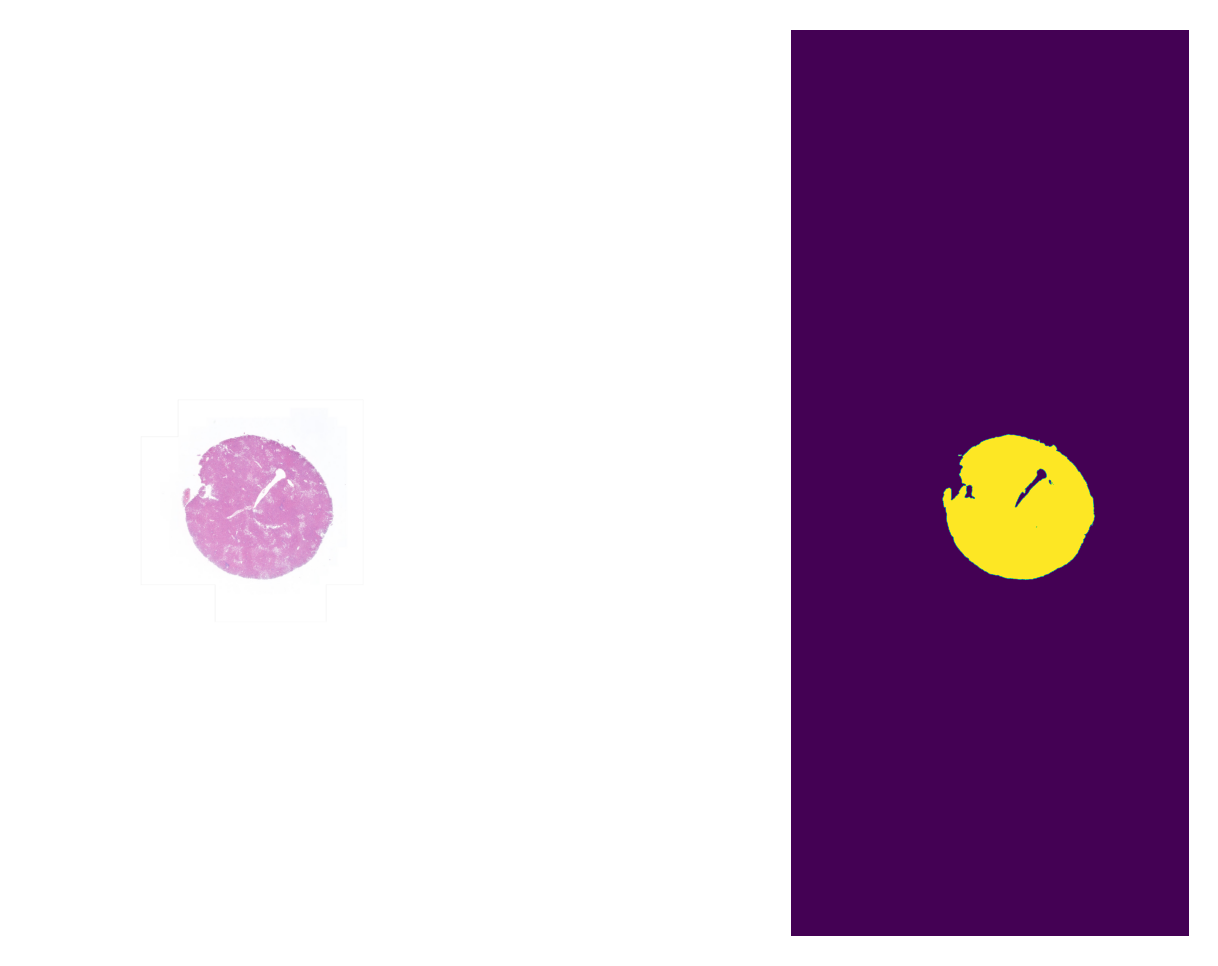

In [25]:
# [Loading the raw prediction]
print('prediction method output is: {}'.format(tissue_mask_output))
mini_wsi_prediction_raw = np.load(tissue_mask_output[0][1]+'.raw.0.npy') # Loading the first prediction [0] based on the output address [1]
print('Raw prediction dimensions: {}'.format(mini_wsi_prediction_raw.shape))

# [Post-processing]
# Simple processing of the raw prediction to generate semantic segmentation task
mini_wsi_prediction = np.argmax(mini_wsi_prediction_raw, axis=-1) # select the class with highest probability
print('Processed prediction dimensions: {}'.format(mini_wsi_prediction.shape))

# [WSI overview extraction]
# Now reading the WSI to extract it's overview
mini_wsi = WSIReader.open(mini_wsi_file_name)
print('WSI original dimensions: {}'.format(mini_wsi.info.level_dimensions[0]))

# using the prediction save_resolution to create the wsi overview at the same resolution
overview_info = {'units': 'mpp', 'resolution': 8.0} # same as save_resolution

# extracting slide overview using `slide_thumbnail` method
mini_wsi_overview = mini_wsi.slide_thumbnail(resolution=overview_info['resolution'], units=overview_info['units'])
print('WSI overview dimensions: {}'.format(mini_wsi_prediction.shape))

ax = plt.subplot(1, 2, 1), plt.imshow(mini_wsi_overview); plt.axis('off')
ax = plt.subplot(1, 2, 2), plt.imshow(mini_wsi_prediction); plt.axis('off')

And that's it!

To once again see how easy it is to use an external model in TIAToolbox's semantic segmentation class, we summarize in pseudo-code, as below:
```
# 1- Define the Pytorch model and load weights
model = get_CNN()
model.load_state_dict(pretrained_weights)

# 2- Define the segmentor and IOconfig
segmentor = SemanticSegmentor(model)
ioconfig = IOSegmentorConfig(...)

# 3- Run the prediction
output = tissue_segmentor.predict([img_paths], save_dir, ioconfig, ...)

```

Feel free to play around with the parameters, models, and experimenting with new images (just remember to run the first cell of this notebook again, so the created folders for the current examples would be removed or alternatively change the `save_dir` parameters in new calls of `predict` function). Currently, we are extending our collection of pre-trained models. To keep a track of them, make sure to follow our releases. You can also check [here](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=architecture#module-tiatoolbox.models.architecture). Furthermore, if you want to use your own pretrained model for semantic segmentation (or any other pixel-wise prediction models) in the TIAToolbox framework, you can follow the instructions in our example notebook on [advanced model techniques](https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/examples/07-advanced-modeling.ipynb) to gain some insights and guidance.
We welcome any trained model in computational pathology (in any task) for addition to TIAToolbox. If you have such a model (in Pytorch) and want to contribute, please contact us or simply create a PR on our GitHub page.
